<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Julia_prog_language.svg/1280px-Julia_prog_language.svg.png" width=300>
</center>

# Introduction to Julia

## Dr. Josh Day

- GitHub: `@joshday`
- Email: josh@seqstat.com
- Slides: https://github.com/joshday/Talks


# Julia Resources

- [https://julialang.org](https://julialang.org)
- [https://juliabox.com](https://juliabox.com) (run Julia on the cloud, free tutorials)
- [https://juliaobserver.com/](https://juliaobserver.com/) (finding packages)
- [https://discourse.julialang.org](https://discourse.julialang.org) (ask for help)
- [http://julialang.slack.com/](http://julialang.slack.com/) (ask for help)
- [https://docs.julialang.org/en/](https://docs.julialang.org/en/) (documentation)

# Motivation

- Do we need another language?
- Let's start with Sapir-Worf Hypothesis

# Sapir-Worf Hypothesis

- Your language influences/determines how you think

**How you solve problems is influenced by your tools**

- e.g. with R, avoid loops 

# The Two-Language Problem

- Write your prototype in an easy language (R)
- Write your final version in a fast language (C++)

# Julia

I claim that:

### 1) Julia is less controlling over how you solve problems
### 2) Julia solves the two-language problem

# What is Julia?
> Julia is a high-level, high-performance dynamic programming language for technical computing, with syntax that is familiar to users of other technical computing environments

- Julia is more than just "Fast R"
    - Performance comes from features that work well together.  
    - You can't just take the magic dust that makes Julia fast and sprinkle it on [language of choice]
    
## Julia Features

- Type system
- Multiple dispatch
- Type Inference
- Metaprogramming (macros)
- Just-in-time (JIT) compilation using LLVM
- Clean, familiar syntax
- Most of Julia is written in Julia!

# Benchmarks

<center><img src="https://julialang.org/images/benchmarks.svg" width=900></center>

# Julia is Just-In-Time Compiled

- The first time a function is run, Julia compiles it

In [1]:
y = rand(10^6)

@time sum(y)

@time sum(y)

  0.044702 seconds (95.32 k allocations: 4.756 MiB, 29.00% gc time)
  0.000598 seconds (5 allocations: 176 bytes)


500043.8571402271

# Generic Code Gets Specialized

- Julia specializes on **types of arguments** (without you telling Julia what those types are)

In [2]:
f(x) = x + 4

@time f(1.0)
@time f(1.0)

  0.003870 seconds (11.24 k allocations: 638.555 KiB)
  0.000001 seconds (5 allocations: 176 bytes)


5.0

In [3]:
@time f(1)
@time f(1)

  0.002339 seconds (1.23 k allocations: 73.730 KiB)
  0.000001 seconds (4 allocations: 160 bytes)


5

# Most of Julia is Written in Julia

- Easy to find out what's going on inside a function 
    - `@edit`
- Also most Julia packages are 100% Julia
    - **Tensorflow**:
    ![](tensorflow.png)
    - **Flux.jl**
    ![](flux.png)

# Julia Makes Use of Metaprogramming

- A function of an expression that can be altered before it is evaluated
- Code that writes code
- Can do everything a function can do plus much more

In [4]:
macro thing(x)
    println(typeof(x))
    :("This is a thing")
end

@thing 1 + 2 + 3

Expr


"This is a thing"

In [5]:
@code_llvm f(1)


; Function f
; Location: In[2]:1
define i64 @julia_f_36347(i64) {
top:
; Function +; {
; Location: int.jl:53
  %1 = add i64 %0, 4
;}
  ret i64 %1
}


- What is the difference between `show` and `@show`?

In [6]:
val = 100
@show val;

val = 100


In [7]:
show(val)

100

## One of the Most Useful Macros: `@time`

- Provides elapsed time **as well as allocations**
- Removing temporary allocations (garbage collection) is expensive!
- It's impossible to oversell how useful this is

In [8]:
@time rand(10^6);

  0.009261 seconds (7 allocations: 7.630 MiB, 47.39% gc time)


# Julia Has a Great Type System

In [9]:
rand(2, 2)

2×2 Array{Float64,2}:
 0.396512  0.700009
 0.721726  0.999401

In [10]:
typeof(1.0)

Float64

In [11]:
typeof(1)

Int64

# Types Define Sets of Things

![](tree.png)

- Abstract types "don't exist".  They define a set of things that behave similarly.
- Concrete types "are real".  They exist in a set of things defined by an abstract type.
    - Concrete types do not have subtypes

Type tree from `Any` to `Float64`:
- Any (abstract)
    - Number (abstract)
        - Real (abstract)
            - AbstractFloat (abstract)
                - Float64 (concrete)
                
Is a `Float64` a `Number`? Yes

Is a `Float64` an `AbstractFloat`? Yes

One "set" is smaller than the other: `AbstractFloat <: Number`

In [12]:
supertype(Float64)

AbstractFloat

In [13]:
supertype(AbstractFloat)

Real

In [14]:
supertype(Real)

Number

In [15]:
supertype(Number)

Any

# Programs are Organized Around Multiple Dispatch

- The idea that different code gets called depending on the types of the arguments
- Multiple dispatch is amazing

In [16]:
f(x::Number) = "This is a Number"
f(x::String) = "This is a String"
f(x) = "This is something else"

f (generic function with 3 methods)

In [17]:
f(1)

"This is a Number"

In [18]:
f("asdf")

"This is a String"

In [19]:
f([1, 2])

"This is something else"

## Quintessential R vs. Julia

- Consider R's `pnorm`, `dnorm`, `qnorm`, etc. family of functions.
- In Julia, multiple dispatch is used to create a grammar/interface for "how to talk about" a set of things
    - What is the interface for probability distributions?

In [20]:
using Distributions

d = Normal(0, 1)
d2 = Gamma(3, 5);

In [21]:
mean(d), var(d), cdf(d, 1)

(0.0, 1.0, 0.841344746068543)

In [22]:
mean(d2), var(d2), cdf(d2, 1)

(15.0, 75.0, 0.0011484812448621334)

## A Concrete Example

- Here is a very naive Newton's algorithm for finding the quantile `q` of a distribution `d`
- I haven't told Julia anything about types, but this will work as long as 
    1. `d` is something that I can calculate the `mean`, `cdf`, and `pdf` of
    2. `q` is a Number
- Also because of the JIT, I get specialized code for each distribution!

In [23]:
function my_quantile(d, q)
    θ = mean(d)
    for i in 1:20
        θ -= (cdf(d, θ) - q) / pdf(d, θ)
    end
    θ
end

my_quantile (generic function with 1 method)

In [24]:
my_quantile(Normal(), .5)

0.0

In [25]:
my_quantile(Gamma(5, 1), .3)

3.6336090829638032

# Julia's Growth (Number of Packages)

![](https://pkg.julialang.org/img/allver.svg)

# Julia's Growth (GitHub Stars)

![](https://pkg.julialang.org/img/stars.svg)

# Pass by Reference

- R makes a copy of function arguments
    - You can't do any damage
    - But you lose performance
- In Julia, you're free to really mess with objects inside a function
- By convention, if you are **mutating** an argument, end the function with `!`

In [26]:
# Don't do this
function totally_safe_function(x)
    x .= 0
end

val = [1,2,3,4]

totally_safe_function(val)

val

4-element Array{Int64,1}:
 0
 0
 0
 0

# Broadcasting

- `sin` of a vector is not defined
- Most languages use the syntactic sugar that `sin` of a vector means "apply `sin` to each element of the vector"
- Julia doesn't, because
    1. It's wrong
    2. It's unnecessary and can be generalized to all functions of singletons

In [27]:
sin(rand(5))

MethodError: MethodError: no method matching sin(::Array{Float64,1})
Closest candidates are:
  sin(!Matched::BigFloat) at mpfr.jl:683
  sin(!Matched::Missing) at math.jl:1056
  sin(!Matched::Complex{Float16}) at math.jl:1005
  ...

- Dot syntax does broadcasting/maps the function to each element

In [28]:
sin.(rand(5))

5-element Array{Float64,1}:
 0.5280721833739159 
 0.8011842530154186 
 0.3021067135780506 
 0.07894317534013369
 0.06603271899990608

- Multiple broadcasting functions can be chained together (without creating temporary copies)

In [29]:
cos.(sin.(abs.(rand(2, 2))))

2×2 Array{Float64,2}:
 0.997827  0.681746
 0.909406  0.708576

# Julia is Lazy

- Many types in Julia are lazy
- `AbstractRange` subtypes store the information for generating a range of numbers, not the numbers themselves.

In [30]:
rng = 1:100

1:100

In [31]:
typeof(rng)

UnitRange{Int64}

In [32]:
fieldnames(typeof(rng))

(:start, :stop)

In [33]:
rng.start, rng.stop

(1, 100)

In [34]:
rng[50]

50

- You can typically turn a lazy type into a "real thing" with `collect`

In [35]:
collect(rng)

100-element Array{Int64,1}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
  89
  90
  91
  92
  93
  94
  95
  96
  97
  98
  99
 100

# For Loops

- **In Julia, loops are fast.  Don't avoid them.**
- It took me several weeks of Julia programming before I shook my R habit of vectorizing everything


- Tip: Use `eachindex` to iterate over the elements of a collection

In [36]:
x = rand(5)

for i in eachindex(x)
    println(x[i])
end

0.9927171265515466
0.054395032238005125
0.6836070695796173
0.23750286565691026
0.7044995338311355


In [37]:
for xi in x
    println(xi)
end

0.9927171265515466
0.054395032238005125
0.6836070695796173
0.23750286565691026
0.7044995338311355


In [38]:
for (i, xi) in enumerate(x)
    println("Element $i is $xi")
end

Element 1 is 0.9927171265515466
Element 2 is 0.054395032238005125
Element 3 is 0.6836070695796173
Element 4 is 0.23750286565691026
Element 5 is 0.7044995338311355


# Anonymous Functions and the `do` Syntax

- An **anonymous function** is a function you probabily won't use again
    - Created with syntax: `(x,y,z) -> x + y + z`
- `do` blocks:
    - An easy way of writing longer anonymous functions
    - For functions that accept a function as its first argument
- The following are different ways of doing the same thing

In [39]:
map(abs, [-1, -2, -3])

3-element Array{Int64,1}:
 1
 2
 3

In [40]:
map(x -> abs(x), [-1, -2, -3])

3-element Array{Int64,1}:
 1
 2
 3

In [41]:
map([-1, -2, -3]) do x
    abs(x)
end

3-element Array{Int64,1}:
 1
 2
 3

# Tuples and NamedTuples

- Efficient way to join heterogenous objects together in a type-stable way

In [42]:
("I", "am", "a", "tuple", 1 , 2, 3.0)

("I", "am", "a", "tuple", 1, 2, 3.0)

- You can also give items a name

In [43]:
nt = (x = 1, y = 2)

(x = 1, y = 2)

In [44]:
nt.x

1

# Creating Your Own Types

- `struct`: Contents that won't change
- `mutable struct`: Contents that may change

In [45]:
struct Population
    x::Vector{Int}
end

struct SampleWithReplacement
    x::Vector{Int}
end

In [46]:
SampleWithReplacement(pop::Population, n) = SampleWithReplacement(rand(pop.x, n))

SampleWithReplacement

In [47]:
pop = Population(collect(1:10))

Population([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [48]:
pop.x

10-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [49]:
SampleWithReplacement(pop, 8)

SampleWithReplacement([10, 9, 9, 5, 8, 9, 5, 4])

# Interop

- You don't need to leave your favorite R/Python/C/Fortran/C++ code behind
- All are easily callable from Julia

## R

You can "send" objects from Julia to R using interpolation syntax `$`

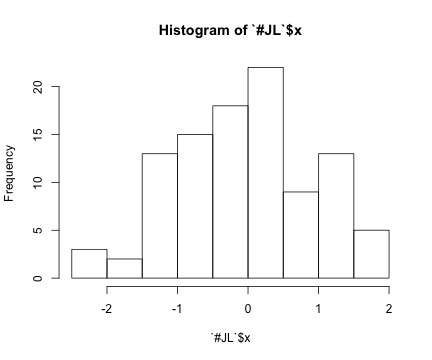

RObject{VecSxp}
$breaks
 [1] -2.5 -2.0 -1.5 -1.0 -0.5  0.0  0.5  1.0  1.5  2.0

$counts
[1]  3  2 13 15 18 22  9 13  5

$density
[1] 0.06 0.04 0.26 0.30 0.36 0.44 0.18 0.26 0.10

$mids
[1] -2.25 -1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75

$xname
[1] "`#JL`$x"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


In [50]:
using RCall

x = randn(100)

R"hist($x)"

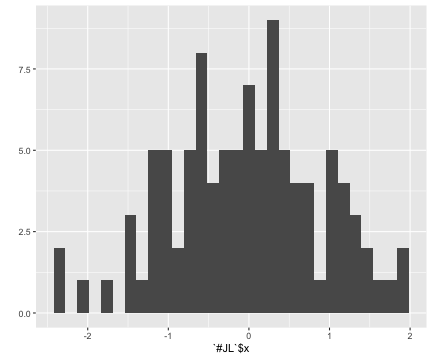

RObject{VecSxp}


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /Users/joshday/.julia/packages/RCall/Q4n8R/src/io.jl:110


In [51]:
R"library(ggplot2); qplot($x)"

## Python

In [52]:
using PyCall

@pyimport numpy.random as nr

nr.rand(3, 4)

3×4 Array{Float64,2}:
 0.775292  0.168649   0.378351  0.607832
 0.357349  0.885507   0.402047  0.443632
 0.879717  0.0249528  0.579264  0.595484

# REPL Modes

- Your first experience with Julia is probably through the REPL (read-eval-print-loop)

There are several **REPL Modes** that can be activated by certain characters:

- `?` (help)
- `]` (package manager)
- `;` (shell)
- `$` (R via [RCall.jl](https://github.com/JuliaInterop/RCall.jl))

# Linear Algebra

- **I could do multiple lectures on numerical linear algebra in Julia.  It's fantastic.**
- Call `BLAS` functions directly
- In-place (mutating) operations lead to huge performance gains!
- Types for storing matrix factorizations for quickly solving linear systems, etc.

In [53]:
using LinearAlgebra

In [54]:
x = randn(10, 2)

lu(x)

LU{Float64,Array{Float64,2}}
L factor:
10×2 Array{Float64,2}:
  1.0         0.0      
  0.657287    1.0      
  0.258778    0.396275 
  0.152751    0.757843 
 -0.18661     0.0376225
  0.49608     0.0977601
 -0.0411215   0.245317 
  0.371992   -0.127662 
 -0.0691495  -0.055911 
  0.595217    0.634234 
U factor:
2×2 Array{Float64,2}:
 0.925101  -1.13541
 0.0        2.33587

In [55]:
c = cholesky(x'x)

Cholesky{Float64,Array{Float64,2}}
U factor:
2×2 UpperTriangular{Float64,Array{Float64,2}}:
 1.40371  0.187416
  ⋅       2.91322 

In [56]:
inv(c)  # You very rarely need to do this

2×2 Array{Float64,2}:
  0.509611  -0.015732
 -0.015732   0.117829

In [57]:
svd(x)

SVD{Float64,Float64,Array{Float64,2}}([0.283147 0.369956; -0.241762 0.266237; … ; -0.018695 -0.0441676; -0.375699 0.692769], [2.92105, 1.39995], [0.0400582 0.999197; 0.999197 -0.0400582])

In [58]:
eigen(x'x)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
2-element Array{Float64,1}:
 1.959854630780974
 8.532524898496206
eigenvectors:
2×2 Array{Float64,2}:
 -0.999197   0.0400582
  0.0400582  0.999197 

# Standard Library

- Some things you may expect to already be in Julia need to be loaded
    - `using Statistics`
    - `using LinearAlgebra`
    - `using DelimitedFiles`